##### fft模块测试

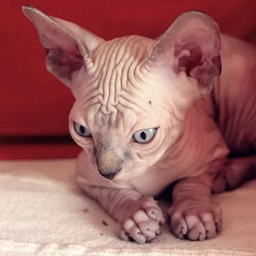

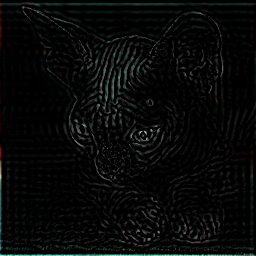

In [9]:
import torch
from torchvision import transforms
from torch.nn import functional as F
from PIL import Image

def fft(x, scale):
    assert scale>2
    x = torch.fft.fft2(x, norm="ortho")#,norm='forward'
    x = torch.fft.fftshift(x, dim=[-2, -1]) 
    c,h,w = x.shape
    x[:,h//2-h//scale:h//2+h//scale,w//2-w//scale:w//2+w//scale ] = 0.0
    x = torch.fft.ifftshift(x, dim=[-2, -1])
    x = torch.fft.ifft2(x, norm="ortho")
    x = torch.real(x)
    x = F.relu(x, inplace=True) #TODO: 要不要加这个relu函数
    return x

if __name__ == "__main__":
    img = Image.open('./face/face.jpg')
    img.show()
    trans_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])
    img_tensor = trans_tensor(img)
    img_tensor_f = fft(img_tensor, 8) #TODO: 这个scale看怎么调比较好
    # 转回图片
    img_array_f = img_tensor_f.permute(1, 2, 0).numpy()
    img_array_f = (img_array_f - img_array_f.min()) / (img_array_f.max() - img_array_f.min())
    img_array_f = (img_array_f * 255).astype('uint8')
    img_f = Image.fromarray(img_array_f)
    img_f.show()
    img_f.save('./face/face_f.jpg')

##### patch_img模块测试

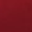

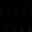

In [4]:
import numpy as np
import math
import torch
from torchvision.transforms import transforms
from PIL import Image


def compute(patch):
    weight, height = patch[0].size
    m = weight
    res = 0
    patch_np = np.array(patch[0]).astype(np.int64)
    diff_horizontal = np.sum(np.abs(patch_np[:, :-1, :] - patch_np[:, 1:, :]))
    diff_vertical = np.sum(np.abs(patch_np[:-1, :, :] - patch_np[1:, :, :]))
    diff_diagonal = np.sum(np.abs(patch_np[:-1, :-1, :] - patch_np[1:, 1:, :]))
    diff_diagonal += np.sum(np.abs(patch_np[1:, :-1, :] - patch_np[:-1, 1:, :]))
    res = diff_horizontal + diff_vertical + diff_diagonal
    return res.sum()


def patch_img(img, img_f, patch_size, height):
    img_width, img_height = img.size
    height = int(height)
    patch_size = int(patch_size)
    num_patch = (height // patch_size) * (height // patch_size)
    patch_list = []
    min_len = min(img_height, img_width)
    rz = transforms.Resize((height, height))
    if min_len < patch_size:
        img = rz(img)
    rp = transforms.RandomCrop(patch_size)
    # 随机生成num_patch个不重复随机种子
    seeds = np.random.choice(100000, num_patch, replace=False)
    for i in range(num_patch):
        seed = seeds[i]
        torch.random.manual_seed(seed)
        rp_img = rp(img)
        rp_img.save(f'./face/face_p_{i}.jpg')
        torch.random.manual_seed(seed)
        rp_img_f = rp(img_f)
        rp_img_f.save(f'./face/face_f_p_{i}.jpg')
        patch_list.append([rp_img, rp_img_f])
    patch_list.sort(key=lambda x: compute(x), reverse=False)
    new_img, new_img_f = patch_list[0][0], patch_list[0][1]
    return new_img, new_img_f

if __name__ == "__main__":
    img = Image.open('./face/face.jpg')
    img_f = Image.open('./face/face_f.jpg')
    new_img, new_img_f = patch_img(img, img_f, 32, 256)
    new_img.show()
    new_img_f.show()
    new_img.save('./face/face_p.jpg')
    new_img_f.save('./face/face_f_p.jpg')
    # 转化成tensor
    to_tensor=transforms.ToTensor()
    new_img_tensor = to_tensor(new_img)
    new_img_f_tensor = to_tensor(new_img_f)

#### cam模块测试

In [3]:
# -*- encoding: utf-8 -*-
'''
@Author  :   Hui Li, Jiangnan University
@Contact :   lihui.cv@jiangnan.edu.cn
@File    :   transformer_cam.py
@Time    :   2023/03/30 18:00:20
'''
# @note import
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision import transforms
import time
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
# from tools.utils import vision_features, save_image_heat_map, save_image_heat_map_list


class Padding_tensor(nn.Module):
    def __init__(self, patch_size):
        super(Padding_tensor, self).__init__()
        self.patch_size = patch_size

    def forward(self, x):
        b, c, h, w = x.shape
        # 计算出能分成多少个patch
        h_patches = int(np.ceil(h / self.patch_size))
        w_patches = int(np.ceil(w / self.patch_size))
        # 计算出需要padding的大小
        h_padding = np.abs(h - h_patches * self.patch_size)
        w_padding = np.abs(w - w_patches * self.patch_size)
        # 进行反射填充
        reflection_padding = [0, w_padding, 0, h_padding]
        reflection_pad = nn.ReflectionPad2d(reflection_padding)
        x = reflection_pad(x)
        return x, [h_patches, w_patches, h_padding, w_padding]# 返回填充后的图片和patch信息
    
    
class PatchEmbed_tensor(nn.Module):
    def __init__(self, patch_size=2):
        super().__init__()
        self.patch_size = patch_size
        self.padding_tensor = Padding_tensor(patch_size)

    def forward(self, x):
        b, c, h, w = x.shape
        x, patches_paddings = self.padding_tensor(x)# 对图片进行填充，得到填充后的图片和patch信息
        h_patches = patches_paddings[0]
        w_patches = patches_paddings[1]
        # -------------------------------------------
        patch_matrix = None
        for i in range(h_patches):
            for j in range(w_patches):
                patch_one = x[:, :, i * self.patch_size: (i + 1) * self.patch_size,
                            j * self.patch_size: (j + 1) * self.patch_size]
                patch_one = patch_one.reshape(-1, c, 1, self.patch_size, self.patch_size)
                if i == 0 and j == 0:
                    patch_matrix = patch_one
                else:
                    patch_matrix = torch.cat((patch_matrix, patch_one), dim=2)
        return patch_matrix, patches_paddings
    
    
class Recons_tensor(nn.Module):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def forward(self, patches_tensor, patches_paddings):
        B, C, N, Ph, Pw = patches_tensor.shape
        h_patches = patches_paddings[0]
        w_patches = patches_paddings[1]
        h_padding = patches_paddings[2]
        w_padding = patches_paddings[3]
        assert N == h_patches * w_patches, \
            f"The number of patches ({N}) doesn't match the Patched_embed operation ({h_patches}*{w_patches})."
        assert Ph == self.patch_size and Pw == self.patch_size, \
            f"The size of patch tensor ({Ph}*{Pw}) doesn't match the patched size ({self.patch_size}*{self.patch_size})."

        patches_tensor = patches_tensor.view(-1, C, N, self.patch_size, self.patch_size)
        # ----------------------------------------
        pic_all = None
        for i in range(h_patches):
            pic_c = None
            for j in range(w_patches):
                if j == 0:
                    pic_c = patches_tensor[:, :, i * w_patches + j, :, :]
                else:
                    pic_c = torch.cat((pic_c, patches_tensor[:, :, i * w_patches + j, :, :]), dim=3)
            if i == 0:
                pic_all = pic_c
            else:
                pic_all = torch.cat((pic_all, pic_c), dim=2)
        b, c, h, w = pic_all.shape
        pic_all = pic_all[:, :, 0:(h-h_padding), 0:(w-w_padding)]
        return pic_all
# -----------------------------------------------------------------------


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        # x = x + 1e-6
        x = self.fc1(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.act(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.fc2(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)

        return x


# self or cross attention
class Attention(nn.Module):
    def __init__(self, dim, n_heads=16, qkv_bias=True, attn_p=0., proj_p=0., cross=False):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        
        # self.recons_tensor = Recons_tensor(2)
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.cross = cross
        if cross:
            self.q_linear = nn.Linear(dim, dim, bias=qkv_bias)
            self.k_linear = nn.Linear(dim, dim, bias=qkv_bias)
            self.v_linear = nn.Linear(dim, dim, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):

        if self.cross:
            n_samples, n_tokens, dim = x[0].shape
            if dim != self.dim:
                raise ValueError

            n_tokens_en = n_tokens
            q = self.q_linear(x[0]).reshape(n_samples, n_tokens, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
            k = self.k_linear(x[1]).reshape(n_samples, n_tokens_en, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
            v = self.v_linear(x[2]).reshape(n_samples, n_tokens_en, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        else:
            n_samples, n_tokens, dim = x.shape
            if dim != self.dim:
                raise ValueError

            qkv = self.qkv(x)  # (n_samples, n_patches, 3 * dim)
            qkv = qkv.reshape(
                n_samples, n_tokens, 3, self.n_heads, self.head_dim
            )  # (n_smaples, n_patches, 3, n_heads, head_dim)
            qkv = qkv.permute(
                2, 0, 3, 1, 4
            )  # (3, n_samples, n_heads, n_patches, head_dim)
            q, k, v = qkv[0], qkv[1], qkv[2]

        k_t = k.transpose(-2, -1)  # (n_samples, n_heads, head_dim, n_patches + 1)
        dp = (q @ k_t) * self.scale  # (n_samples, n_heads, n_patches, n_patches)
        # exp(-x)
        # dp 过大，softmax之后数值可能溢出
        if self.cross:
            # t_str = time.time()
            # dp_s = dp.softmax(dim=-1)
            # vision_features(dp_s, 'atten', 'dp_'+str(t_str))
            dp = -1 * dp
            # attn = dp.softmax(dim=-1)
            # vision_features(attn, 'atten', 'dp_v_'+str(t_str))
        attn = dp.softmax(dim=-1)  # (n_samples, n_heads, n_patches, n_patches)
        attn = self.attn_drop(attn)

        weighted_avg = attn @ v  # (n_samples, n_heads, n_patches +1, head_dim)
        weighted_avg = weighted_avg.transpose(1, 2)  # (n_samples, n_patches + 1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches + 1, dim)

        x = self.proj(weighted_avg)  # (n_samples, n_patches + 1, dim)
        x = self.proj_drop(x)  # (n_samples, n_patches + 1, dim)

        # if self.cross:
        #     x_temp = x.view(1, 256, 128, 2, 2).permute(0, 2, 1, 3, 4)
        #     x_temp = self.recons_tensor(x_temp, [16,16,0,0])  # B, C, H, W
        #     vision_features(x_temp, 'atten', 'attn_x')
        
        return x


class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0., cross=False):
        super().__init__()
        self.cross = cross
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(
            dim,
            n_heads=n_heads,
            qkv_bias=qkv_bias,
            attn_p=attn_p,
            proj_p=p,
            cross=cross
        )
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(
            in_features=dim,
            hidden_features=hidden_features,
            out_features=dim,
        )

    def forward(self, x):
        if self.cross:
            x_ = [self.norm1(_x) for _x in x]
            # x_ = x
            out = x[2] + self.attn(x_)
            out = out + self.mlp(self.norm2(out))
            out = [x_[0], out, out]
        else:
            out = x + self.attn(self.norm1(x))
            out = out + self.mlp(self.norm2(out))
        
        return out
# --------------------------------------------------------------------------------------


class self_atten_module(nn.Module):
    def __init__(self, embed_dim, num_p, depth, n_heads=16,
                 mlp_ratio=4., qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList(
            [
                Block(dim=embed_dim, n_heads=n_heads,
                      mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, p=p, attn_p=attn_p, cross=False)
                for _ in range(depth)
            ]
        )
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)

    def forward(self, x_in):
        # x_ori = x_in
        x = x_in
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)
        x_self = x
        # x_self = x_in + x
        return x_self


class cross_atten_module(nn.Module):
    def __init__(self, embed_dim, num_patches, depth, n_heads=16,
                 mlp_ratio=4., qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList(
            [
                Block(dim=embed_dim, n_heads=n_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, p=p, attn_p=attn_p,
                      cross=True)
                if i == 0 else
                Block(dim=embed_dim, n_heads=n_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, p=p, attn_p=attn_p,
                      cross=True)
                for i in range(depth)
            ]
        )
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)

    def forward(self, x1_ori, x2_ori): # 传的时候注意，x1是freq，x2是patch
        x1 = x1_ori
        x2 = x2_ori
        x2 = self.pos_drop(x2)
        x = [x1, x2, x2]
        for block in self.blocks:
            x = block(x)
            x[2] = self.norm(x[2])
        x_self = x[2]
        # x_self = x2_ori + x[2]
        return x_self
    

class self_atten(nn.Module):
    def __init__(self, patch_size, embed_dim, num_patches, depth_self, n_heads=16,
                 mlp_ratio=4., qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.patch_embed_tensor = PatchEmbed_tensor(patch_size)
        self.recons_tensor = Recons_tensor(patch_size)
        self.self_atten1 = self_atten_module(embed_dim, num_patches, depth_self,
                                              n_heads, mlp_ratio, qkv_bias, p, attn_p)
        self.self_atten2 = self_atten_module(embed_dim, num_patches, depth_self,
                                                   n_heads, mlp_ratio, qkv_bias, p, attn_p)

    def forward(self, x1, x2, last=False):
        # patch
        x_patched1, patches_paddings = self.patch_embed_tensor(x1)
        # B, C, N, Ph, Pw = x_patched1.shape
        x_patched2, _ = self.patch_embed_tensor(x2)
        # B, C, N, Ph, Pw = x_patched1.shape
        b, c, n, h, w = x_patched1.shape
        # b, n, c*h*w
        x_patched1 = x_patched1.transpose(2, 1).contiguous().view(b, n, c * h * w)
        x_patched2 = x_patched2.transpose(2, 1).contiguous().view(b, n, c * h * w)
        x1_self_patch = self.self_atten1(x_patched1)
        x2_self_patch = self.self_atten2(x_patched2)
       
        # reconstruct
        if last is False:
            x1_self_patch = x1_self_patch.view(b, n, c, h, w).permute(0, 2, 1, 3, 4)
            x_self1 = self.recons_tensor(x1_self_patch, patches_paddings)  # B, C, H, W
            x2_self_patch = x2_self_patch.view(b, n, c, h, w).permute(0, 2, 1, 3, 4)
            x_self2 = self.recons_tensor(x2_self_patch, patches_paddings)  # B, C, H, W
        else:
            x_self1 = x1_self_patch
            x_self2 = x2_self_patch

        return x_self1, x_self2, patches_paddings


class cross_atten(nn.Module):
    def __init__(self, patch_size, embed_dim, num_patches, depth_self, depth_cross, n_heads=16,
                 mlp_ratio=4., qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.patch_embed_tensor = PatchEmbed_tensor(patch_size)
        self.recons_tensor = Recons_tensor(patch_size)
        
        self.cross_atten = cross_atten_module(embed_dim, num_patches, depth_cross,
                                                     n_heads, mlp_ratio, qkv_bias, p, attn_p)
        # self.cross_atten1 = cross_atten_module(embed_dim, num_patches, depth_cross,
        #                                              n_heads, mlp_ratio, qkv_bias, p, attn_p)
        # self.cross_atten2 = cross_atten_module(embed_dim, num_patches, depth_cross,
        #                                              n_heads, mlp_ratio, qkv_bias, p, attn_p)
        # self.cross_atten = patch_cross_atten_module(img_size, patch_size, embed_dim, num_patches, depth_cross,
        #                                              n_heads, mlp_ratio, qkv_bias, p, attn_p)

    def forward(self, x1, x2, patches_paddings): # x1是freq，x2是patch
        # patch
        x_patched1, patches_paddings = self.patch_embed_tensor(x1)
        # B, C, N, Ph, Pw = x_patched1.shape
        x_patched2, _ = self.patch_embed_tensor(x2)
        # B, C, N, Ph, Pw = x_patched1.shape
        b, c, n, h, w = x_patched1.shape
        # b, n, c*h*w
        x1_self_patch = x_patched1.transpose(2, 1).contiguous().view(b, n, c * h * w)
        x2_self_patch = x_patched2.transpose(2, 1).contiguous().view(b, n, c * h * w)
        
        x_in1 = x1_self_patch
        x_in2 = x2_self_patch
        out = self.cross_atten(x_in1, x_in2)
        
        out = out.view(b, n, c, h, w).permute(0, 2, 1, 3, 4)
        out_all = self.recons_tensor(out, patches_paddings)  # B, C, H, W
        
        return out_all
        # return out_all, x_self1, x_self2, cross1_all, cross2_all


class cross_encoder(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim, num_patches, depth_self, depth_cross, n_heads=16,
                 mlp_ratio=4., qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.num_patches = num_patches
        self.img_size = img_size
        self.patch_size = patch_size
        # self.shift_size = int(img_size / 2)
        self.depth_cross = depth_cross
        # self.depth_cross = 0

        self.self_atten_block1 = self_atten(self.patch_size, embed_dim, num_patches, depth_self,
                                              n_heads, mlp_ratio, qkv_bias, p, attn_p)
        self.self_atten_block2 = self_atten(self.patch_size, embed_dim, num_patches, depth_self,
                                                   n_heads, mlp_ratio, qkv_bias, p, attn_p)
        
        self.cross_atten_block = cross_atten(self.patch_size, embed_dim, self.num_patches, depth_self,
                                               depth_cross, n_heads, mlp_ratio, qkv_bias, p, attn_p)

    def forward(self, x1, x2):
        # x1 -->> ir, x2 -->> vi
        # self-attention
        x1_atten, x2_atten, paddings = self.self_atten_block1(x1, x2)
        x1_a, x2_a = x1_atten, x2_atten
        x1_atten, x2_atten, _ = self.self_atten_block2(x1_atten, x2_atten)
        roll_x_self1 = x1_atten
        roll_x_self2 = x2_atten
        # -------------------------------------
        # cross attention
        if self.depth_cross > 0:
            out = self.cross_atten_block(x1_atten, x2_atten, paddings)
        else:
            out = roll_x_self1 + roll_x_self2
            x_self1, x_self2, x_cross1, x_cross2 = roll_x_self1, roll_x_self2, roll_x_self1, roll_x_self2
        # -------------------------------------
        return out
    
class CAM(nn.Module):
    def __init__(self, img_size, patch_size, part_out,  
                 depth_self, depth_cross, n_heads, mlp_ratio, qkv_bias, p, attn_p):
        super().__init__()
        self.img_size = img_size  # 32*32
        self.patch_size = patch_size  # 2*2
        self.part_out = part_out  # 3
        self.patch_embed_tensor = PatchEmbed_tensor(img_size)
        self.recons_tensor = Recons_tensor(img_size)
        self.embed_dim = part_out * patch_size * patch_size  # 512
        self.num_patches = int(img_size / patch_size) * int(img_size / patch_size)  # 16*16
        
        self.cross_atten_block = cross_encoder(self.img_size, self.patch_size, self.embed_dim, self.num_patches, depth_self,
                                               depth_cross, n_heads, mlp_ratio, qkv_bias, p, attn_p)

    def forward(self, x_f, x_p):
        x_f_patched, patches_paddings = self.patch_embed_tensor(x_f)
        b, c, N, h, w = x_f_patched.shape
        x_p_patched, _ = self.patch_embed_tensor(x_p)
        out = []
        x_f_cross = []
        x_p_cross = []
        for i in range(N):
            out_p = self.cross_atten_block(x_f_patched[:, :, i, :, :], x_p_patched[:, :, i, :, :])
            # x_f_cross.append(x_f_cross_p)
            # x_p_cross.append(x_p_cross_p)
            out.append(out_p)
        if b == 1:
            # x_f_cross = torch.cat(x_f_cross, dim=0).unsqueeze(dim=1)
            # x_p_cross = torch.cat(x_p_cross, dim=0).unsqueeze(dim=1)
            out = torch.cat(out, dim=0)
        else:
            # x_f_cross = torch.cat(x_f_cross, dim=0)
            # x_p_cross = torch.cat(x_p_cross, dim=0)
            out = torch.cat(out, dim=0)

        # out = out.permute(1, 2, 0, 3, 4)  # b, c, N, h, w
        # out = self.recons_tensor(out, patches_paddings)
        out[..., :2] = out[..., :2] * 255
        # out = out * 255
        # outputs = {'out': out}

        return out
            
if __name__ == '__main__': #@note if_main
    model = CAM(img_size=32, patch_size=2, part_out=3,  
                 depth_self=1, depth_cross=1, n_heads=4, mlp_ratio=4., qkv_bias=True, p=0., attn_p=0)
    img_f=Image.open('/hexp/ly/PF_CAM/module_test/00000_p_f.png')
    img_p=Image.open('/hexp/ly/PF_CAM/module_test/00000_p.png')
    x_f = transforms.ToTensor()(img_f).unsqueeze(0)
    x_p = transforms.ToTensor()(img_p).unsqueeze(0)
    out = model(x_f, x_p)
    print(out.shape)
    # 把out转为图片
    out_detached = out.detach()
    out_np = out_detached.squeeze(0).permute(1, 2, 0).numpy()
    out_norm = (out_np - out_np.min()) / (out_np.max() - out_np.min())
    out_stren = (out_norm*255).astype('uint8')
    out_img = Image.fromarray(out_stren)
    out_img.save('/hexp/ly/PF_CAM/module_test/00000_out.png')
    # out_img.show()
    # print(model)

    # img = Image.open('./face/face.jpg')
    # img.show()
    # trans_tensor = transforms.Compose([
    #     transforms.ToTensor(),
    #     transforms.Normalize([0.485, 0.456, 0.406],
    #                          [0.229, 0.224, 0.225]),
    # ])
    # img_tensor = trans_tensor(img)
    # img_tensor_f = fft(img_tensor, 8) #TODO: 这个scale看怎么调比较好
    # # 转回图片
    # img_array_f = img_tensor_f.permute(1, 2, 0).numpy()
    # img_array_f = (img_array_f - img_array_f.min()) / (img_array_f.max() - img_array_f.min())
    # img_array_f = (img_array_f * 255).astype('uint8')
    # img_f = Image.fromarray(img_array_f)
    # img_f.show()
    # img_f.save('./face/face_f.jpg')

# 类之间的关系图：
# cross_encoder
#   ├── self_atten
#   │     ├── PatchEmbed_tensor
#   │     │     └── Padding_tensor
#   │     ├── self_atten_module
#   │     │     └── Block
#   │     │           ├── Attention
#   │     │           └── MLP
#   │     └── Recons_tensor
#   ├── cross_atten
#   │     ├── PatchEmbed_tensor
#   │     │     └── Padding_tensor
#   │     ├── cross_atten_module
#   │     │     └── Block
#   │     │           ├── Attention
#   │     │           └── MLP
#   │     └── Recons_tensor
#   └── Recons_tensor

torch.Size([1, 3, 32, 32])


#### cam模块修改测试

In [3]:
# -*- encoding: utf-8 -*-
'''
@Author  :   Hui Li, Jiangnan University
@Contact :   lihui.cv@jiangnan.edu.cn
@File    :   transformer_cam.py
@Time    :   2023/03/30 18:00:20
'''
# @note import
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision import transforms
import time
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
# from tools.utils import vision_features, save_image_heat_map, save_image_heat_map_list


class Padding_tensor(nn.Module):
    def __init__(self, patch_size):
        super(Padding_tensor, self).__init__()
        self.patch_size = patch_size

    def forward(self, x):
        b, c, h, w = x.shape
        # 计算出能分成多少个patch
        h_patches = int(np.ceil(h / self.patch_size))
        w_patches = int(np.ceil(w / self.patch_size))
        # 计算出需要padding的大小
        h_padding = np.abs(h - h_patches * self.patch_size)
        w_padding = np.abs(w - w_patches * self.patch_size)
        # 进行反射填充
        reflection_padding = [0, w_padding, 0, h_padding]
        reflection_pad = nn.ReflectionPad2d(reflection_padding)
        x = reflection_pad(x)
        return x, [h_patches, w_patches, h_padding, w_padding]# 返回填充后的图片和patch信息
    
    
class PatchEmbed_tensor(nn.Module):
    def __init__(self, patch_size=2):
        super().__init__()
        self.patch_size = patch_size
        self.padding_tensor = Padding_tensor(patch_size)

    def forward(self, x):
        b, c, h, w = x.shape
        x, patches_paddings = self.padding_tensor(x)# 对图片进行填充，得到填充后的图片和patch信息
        h_patches = patches_paddings[0]
        w_patches = patches_paddings[1]
        # -------------------------------------------
        patch_matrix = None
        for i in range(h_patches):
            for j in range(w_patches):
                patch_one = x[:, :, i * self.patch_size: (i + 1) * self.patch_size,
                            j * self.patch_size: (j + 1) * self.patch_size]
                patch_one = patch_one.reshape(-1, c, 1, self.patch_size, self.patch_size)
                if i == 0 and j == 0:
                    patch_matrix = patch_one
                else:
                    patch_matrix = torch.cat((patch_matrix, patch_one), dim=2)
        return patch_matrix, patches_paddings
    
    
class Recons_tensor(nn.Module):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def forward(self, patches_tensor, patches_paddings):
        B, C, N, Ph, Pw = patches_tensor.shape
        h_patches = patches_paddings[0]
        w_patches = patches_paddings[1]
        h_padding = patches_paddings[2]
        w_padding = patches_paddings[3]
        assert N == h_patches * w_patches, \
            f"The number of patches ({N}) doesn't match the Patched_embed operation ({h_patches}*{w_patches})."
        assert Ph == self.patch_size and Pw == self.patch_size, \
            f"The size of patch tensor ({Ph}*{Pw}) doesn't match the patched size ({self.patch_size}*{self.patch_size})."

        patches_tensor = patches_tensor.view(-1, C, N, self.patch_size, self.patch_size)
        # ----------------------------------------
        pic_all = None
        for i in range(h_patches):
            pic_c = None
            for j in range(w_patches):
                if j == 0:
                    pic_c = patches_tensor[:, :, i * w_patches + j, :, :]
                else:
                    pic_c = torch.cat((pic_c, patches_tensor[:, :, i * w_patches + j, :, :]), dim=3)
            if i == 0:
                pic_all = pic_c
            else:
                pic_all = torch.cat((pic_all, pic_c), dim=2)
        b, c, h, w = pic_all.shape
        pic_all = pic_all[:, :, 0:(h-h_padding), 0:(w-w_padding)]
        return pic_all
# -----------------------------------------------------------------------


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        # x = x + 1e-6
        x = self.fc1(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.act(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.fc2(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)

        return x


# self or cross attention
class Attention(nn.Module):
    def __init__(self, dim, n_heads=16, qkv_bias=True, attn_p=0., proj_p=0., cross=False):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        
        # self.recons_tensor = Recons_tensor(2)
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.cross = cross
        if cross:
            self.q_linear = nn.Linear(dim, dim, bias=qkv_bias)
            self.k_linear = nn.Linear(dim, dim, bias=qkv_bias)
            self.v_linear = nn.Linear(dim, dim, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):

        if self.cross:
            n_samples, n_tokens, dim = x[0].shape
            if dim != self.dim:
                raise ValueError

            n_tokens_en = n_tokens
            q = self.q_linear(x[0]).reshape(n_samples, n_tokens, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
            k = self.k_linear(x[1]).reshape(n_samples, n_tokens_en, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
            v = self.v_linear(x[2]).reshape(n_samples, n_tokens_en, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        else:
            n_samples, n_tokens, dim = x.shape
            if dim != self.dim:
                raise ValueError

            qkv = self.qkv(x)  # (n_samples, n_patches, 3 * dim)
            qkv = qkv.reshape(
                n_samples, n_tokens, 3, self.n_heads, self.head_dim
            )  # (n_smaples, n_patches, 3, n_heads, head_dim)
            qkv = qkv.permute(
                2, 0, 3, 1, 4
            )  # (3, n_samples, n_heads, n_patches, head_dim)
            q, k, v = qkv[0], qkv[1], qkv[2]

        k_t = k.transpose(-2, -1)  # (n_samples, n_heads, head_dim, n_patches + 1)
        dp = (q @ k_t) * self.scale  # (n_samples, n_heads, n_patches, n_patches)
        # exp(-x)
        # dp 过大，softmax之后数值可能溢出
        # if self.cross:
            # t_str = time.time()
            # dp_s = dp.softmax(dim=-1)
            # vision_features(dp_s, 'atten', 'dp_'+str(t_str))
            # dp = -1 * dp
            # attn = dp.softmax(dim=-1)
            # vision_features(attn, 'atten', 'dp_v_'+str(t_str))
        attn = dp.softmax(dim=-1)  # (n_samples, n_heads, n_patches, n_patches)
        attn = self.attn_drop(attn)

        weighted_avg = attn @ v  # (n_samples, n_heads, n_patches +1, head_dim)
        weighted_avg = weighted_avg.transpose(1, 2)  # (n_samples, n_patches + 1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches + 1, dim)

        x = self.proj(weighted_avg)  # (n_samples, n_patches + 1, dim)
        x = self.proj_drop(x)  # (n_samples, n_patches + 1, dim)

        # if self.cross:
        #     x_temp = x.view(1, 256, 128, 2, 2).permute(0, 2, 1, 3, 4)
        #     x_temp = self.recons_tensor(x_temp, [16,16,0,0])  # B, C, H, W
        #     vision_features(x_temp, 'atten', 'attn_x')
        
        return x


class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0., cross=False):
        super().__init__()
        self.cross = cross
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(
            dim,
            n_heads=n_heads,
            qkv_bias=qkv_bias,
            attn_p=attn_p,
            proj_p=p,
            cross=cross
        )
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(
            in_features=dim,
            hidden_features=hidden_features,
            out_features=dim,
        )

    def forward(self, x):
        if self.cross:
            x_ = [self.norm1(_x) for _x in x]
            # x_ = x
            out = x[2] + self.attn(x_)
            out = out + self.mlp(self.norm2(out))
            out = [x_[0], out, out]
        else:
            out = x + self.attn(self.norm1(x))
            out = out + self.mlp(self.norm2(out))
        
        return out
# --------------------------------------------------------------------------------------


class self_atten_module(nn.Module):
    def __init__(self, embed_dim, num_p, depth, n_heads=4,
                 mlp_ratio=4., qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList(
            [
                Block(dim=embed_dim, n_heads=n_heads,
                      mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, p=p, attn_p=attn_p, cross=False)
                for _ in range(depth)
            ]
        )
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)

    def forward(self, x_in):
        x = x_in
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)
        x_self = x
        return x_self


class cross_atten_module(nn.Module):
    def __init__(self, embed_dim, num_patches, depth, n_heads=4,
                 mlp_ratio=4., qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList(
            [
                Block(dim=embed_dim, n_heads=n_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, p=p, attn_p=attn_p,
                      cross=True)
                if i == 0 else
                Block(dim=embed_dim, n_heads=n_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, p=p, attn_p=attn_p,
                      cross=True)
                for i in range(depth)
            ]
        )
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)

    def forward(self, x1_ori, x2_ori): # 传的时候注意，x1是freq，x2是patch
        x1 = x1_ori
        x2 = x2_ori
        x2 = self.pos_drop(x2)
        x = [x1, x2, x2]
        for block in self.blocks:
            x = block(x)
            x[2] = self.norm(x[2])
        x_self = x[2]
        return x_self
    

class self_atten(nn.Module):
    def __init__(self, patch_size, embed_dim, num_patches, depth_self, n_heads=4,
                 mlp_ratio=4., qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.patch_embed_tensor = PatchEmbed_tensor(patch_size)
        self.recons_tensor = Recons_tensor(patch_size)
        self.self_atten1 = self_atten_module(embed_dim, num_patches, depth_self,
                                              n_heads, mlp_ratio, qkv_bias, p, attn_p)
        self.self_atten2 = self_atten_module(embed_dim, num_patches, depth_self,
                                                   n_heads, mlp_ratio, qkv_bias, p, attn_p)

    def forward(self, x1, x2, last=False):
        # patch
        x_patched1, patches_paddings = self.patch_embed_tensor(x1)
        # B, C, N, Ph, Pw = x_patched1.shape
        x_patched2, _ = self.patch_embed_tensor(x2)
        # B, C, N, Ph, Pw = x_patched1.shape
        b, c, n, h, w = x_patched1.shape
        # b, n, c*h*w
        x_patched1 = x_patched1.transpose(2, 1).contiguous().view(b, n, c * h * w)
        x_patched2 = x_patched2.transpose(2, 1).contiguous().view(b, n, c * h * w)
        x1_self_patch = self.self_atten1(x_patched1)
        x2_self_patch = self.self_atten2(x_patched2)
       
        # reconstruct
        if last is False:
            x1_self_patch = x1_self_patch.view(b, n, c, h, w).permute(0, 2, 1, 3, 4)
            x_self1 = self.recons_tensor(x1_self_patch, patches_paddings)  # B, C, H, W
            x2_self_patch = x2_self_patch.view(b, n, c, h, w).permute(0, 2, 1, 3, 4)
            x_self2 = self.recons_tensor(x2_self_patch, patches_paddings)  # B, C, H, W
        else:
            x_self1 = x1_self_patch
            x_self2 = x2_self_patch

        return x_self1, x_self2, patches_paddings


class cross_atten(nn.Module):
    def __init__(self, patch_size, embed_dim, num_patches, depth_self, depth_cross, n_heads=4,
                 mlp_ratio=4., qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.patch_embed_tensor = PatchEmbed_tensor(patch_size)
        self.recons_tensor = Recons_tensor(patch_size)
        
        self.cross_atten = cross_atten_module(embed_dim, num_patches, depth_cross,
                                                     n_heads, mlp_ratio, qkv_bias, p, attn_p)

    def forward(self, x1, x2, patches_paddings): # x1是freq，x2是patch
        # patch
        x_patched1, patches_paddings = self.patch_embed_tensor(x1)
        # B, C, N, Ph, Pw = x_patched1.shape
        x_patched2, _ = self.patch_embed_tensor(x2)
        # B, C, N, Ph, Pw = x_patched1.shape
        b, c, n, h, w = x_patched1.shape
        # b, n, c*h*w
        x1_self_patch = x_patched1.transpose(2, 1).contiguous().view(b, n, c * h * w)
        x2_self_patch = x_patched2.transpose(2, 1).contiguous().view(b, n, c * h * w)
        
        x_in1 = x1_self_patch
        x_in2 = x2_self_patch
        out = self.cross_atten(x_in1, x_in2)
        
        out = out.view(b, n, c, h, w).permute(0, 2, 1, 3, 4)
        out_all = self.recons_tensor(out, patches_paddings)  # B, C, H, W
        
        return out_all


class cross_encoder(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim, num_patches, depth_self, depth_cross, n_heads=4,
                 mlp_ratio=4., qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.num_patches = num_patches
        self.img_size = img_size
        self.patch_size = patch_size
        self.depth_cross = depth_cross

        self.self_atten_block1 = self_atten(self.patch_size, embed_dim, num_patches, depth_self,
                                              n_heads, mlp_ratio, qkv_bias, p, attn_p)
        self.self_atten_block2 = self_atten(self.patch_size, embed_dim, num_patches, depth_self,
                                                   n_heads, mlp_ratio, qkv_bias, p, attn_p)
        
        self.cross_atten_block = cross_atten(self.patch_size, embed_dim, self.num_patches, depth_self,
                                               depth_cross, n_heads, mlp_ratio, qkv_bias, p, attn_p)

    def forward(self, x1, x2):
        # x1 -->> freq, x2 -->> patch
        # self-attention
        x1_atten, x2_atten, paddings = self.self_atten_block1(x1, x2)
        x1_atten, x2_atten, _ = self.self_atten_block2(x1_atten, x2_atten)
        # -------------------------------------
        # cross attention
        out = self.cross_atten_block(x1_atten, x2_atten, paddings)
        # -------------------------------------
        return out
    
class CAM(nn.Module):
    def __init__(self, img_size, patch_size, part_out,  
                 depth_self, depth_cross, n_heads, mlp_ratio, qkv_bias, p, attn_p):
        super().__init__()
        self.img_size = img_size  # 32*32
        self.patch_size = patch_size  # 2*2
        self.part_out = part_out  # 3
        self.embed_dim = part_out * patch_size * patch_size  # 512
        self.num_patches = int(img_size / patch_size) * int(img_size / patch_size)  # 16*16
        
        self.cross_atten_block = cross_encoder(self.img_size, self.patch_size, self.embed_dim, self.num_patches, depth_self,
                                               depth_cross, n_heads, mlp_ratio, qkv_bias, p, attn_p)

    def forward(self, x_f, x_p):
        out = self.cross_atten_block(x_f, x_p)
        out[..., :2] = out[..., :2] * 255
        return out
            
if __name__ == '__main__': #@note if_main
    model = CAM(img_size=32, patch_size=2, part_out=3,  
                 depth_self=1, depth_cross=1, n_heads=4, mlp_ratio=4., qkv_bias=True, p=0., attn_p=0)
    img_f=Image.open('/hexp/ly/PF_CAM/module_test/00000_p_f.png')
    img_p=Image.open('/hexp/ly/PF_CAM/module_test/00000_p.png')
    x_f = transforms.ToTensor()(img_f).unsqueeze(0)
    x_p = transforms.ToTensor()(img_p).unsqueeze(0)
    out = model(x_f, x_p)
    print(out.shape)
    # 把out转为图片
    out_detached = out.detach()
    out_np = out_detached.squeeze(0).permute(1, 2, 0).numpy()
    out_norm = (out_np - out_np.min()) / (out_np.max() - out_np.min())
    out_stren = (out_norm*255).astype('uint8')
    out_img = Image.fromarray(out_stren)
    out_img.save('/hexp/ly/PF_CAM/module_test/00000_out_modified.png')

# 类之间的关系图：
# cross_encoder
#   ├── self_atten
#   │     ├── PatchEmbed_tensor
#   │     │     └── Padding_tensor
#   │     ├── self_atten_module
#   │     │     └── Block
#   │     │           ├── Attention
#   │     │           └── MLP
#   │     └── Recons_tensor
#   ├── cross_atten
#   │     ├── PatchEmbed_tensor
#   │     │     └── Padding_tensor
#   │     ├── cross_atten_module
#   │     │     └── Block
#   │     │           ├── Attention
#   │     │           └── MLP
#   │     └── Recons_tensor
#   └── Recons_tensor

torch.Size([1, 3, 32, 32])


#### 保存频率图片代码